In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
# from jupyterthemes import jtplot

In [20]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [4]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

In [4]:
def plot_regions(experiments : list, regions : list, colors : list = None):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//3, i%3            
            if i == len(regions) - 1:   # Set labels from last region
                li = plot_region(xp, r, ax=ax[j][k], lb=xp.name)
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title('Au_4f')
                ax[j][k].get_legend().remove()
            else:
                li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

### Background subtraction class (dev) 

In [5]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

NameError: name 'trim_exps' is not defined

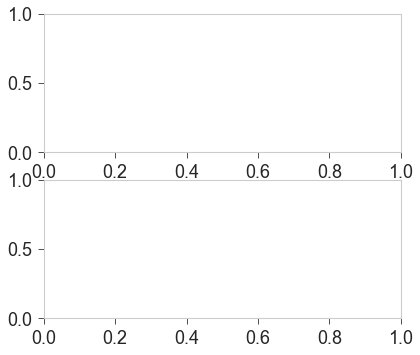

In [6]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

In [ ]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

In [ ]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

# Pre-processing of data FBI on Cu monocrystal
1- Sublimations in UHV, measurement in ARPES chamber

## Import data

In [12]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/G2_Cu/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    print(os.path.split(f)[1])

20220630_Cu_G2SL_subl_90min.xy
20220630_Cu_G2SL_subl_90min_lowstep.xy


In [13]:
experiments = [xps_data_import(path=f,) for f in files]
for xp in experiments[1:]:
    xp.name = xp.name.replace('Cu_', '').replace('_subl_', ' ')

In [17]:
experiments[1].dfx

range        Si_2p              O_1s             N_1s            Si_2s  \
properties  energy    counts  energy    counts energy    counts energy   
0           106.71  4.964433  541.71  3.324367  412.0  2.958660  160.0   
1           106.61  4.976255  541.61  3.310149  411.9  2.949164  159.9   
2           106.51  5.051261  541.51  3.279669  411.8  2.939853  159.8   
3           106.41  4.999133  541.41  3.293231  411.7  2.943949  159.7   
4           106.31  5.013582  541.31  3.265226  411.6  2.939898  159.6   
...            ...       ...     ...       ...    ...       ...    ...   
7013           NaN       NaN     NaN       NaN    NaN       NaN    NaN   
7014           NaN       NaN     NaN       NaN    NaN       NaN    NaN   
7015           NaN       NaN     NaN       NaN    NaN       NaN    NaN   
7016           NaN       NaN     NaN       NaN    NaN       NaN    NaN   
7017           NaN       NaN     NaN       NaN    NaN       NaN    NaN   

range                   C_1s            Cu_2p            survey_hd             
properties    counts  energy    counts energy     counts    energy     counts  
0           4.603084  299.71  3.295359  960.0  108.48711    1400.0  90.656885  
1           4.601611  299.61  3.369500  959.9  106.87808    1399.8  89.220380  
2           4.636090  299.51  3.357837  959.8  108.51179    1399.6  89.245142  
3           4.632331  299.41  3.357344  959.7  110.64326    1399.4  87.201979  
4           4.658160  299.31  3.339964  959.6  110.56584    1399.2  86.900782  
...              ...     ...       ...    ...        ...       ...        ...  
7013             NaN     NaN       NaN    NaN        NaN      -2.6   0.447826  
7014             NaN     NaN       NaN    NaN        NaN      -2.8   0.416064  
7015             NaN     NaN       NaN    NaN        NaN      -3.0   0.457780  
7016             NaN     NaN       NaN    NaN        NaN      -3.2   0.448619  
7017             NaN     NaN       NaN    NaN        NaN      -3.4   0.470255  

[7018 rows x 14 columns]

### Change Ba3d5/2 to Ba 3d

In [6]:
for xp in experiments:
    try:
        xp.dfx.rename_axis({'Ba3d5/2': 'Ba_3d'}, axis=1, copy=False, inplace=True)
    except KeyError:
        pass

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Crop regions

Text(0.5, 1.0, 'Si_2p')

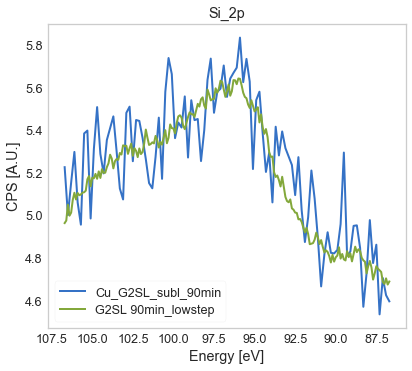

In [45]:
region = 'Si_2p'

for xp in experiments:
#     xp_new = crop_spectrum(xp, region=region, eup=407, edw=397, inplace=True)
    plot_region(xp, region)
cosmetics_plot()
plt.title(region)

### Bulk subtract background

Cu_G2SL_subl_90min C_1s
Cu_G2SL_subl_90min O_1s
Cu_G2SL_subl_90min N_1s
Cu_G2SL_subl_90min Si_2p
Cu_G2SL_subl_90min Si_2s
G2SL 90min_lowstep C_1s
G2SL 90min_lowstep O_1s
G2SL 90min_lowstep N_1s
G2SL 90min_lowstep Si_2p
G2SL 90min_lowstep Si_2s
Max iterations exceeded, subtract ALS baseline


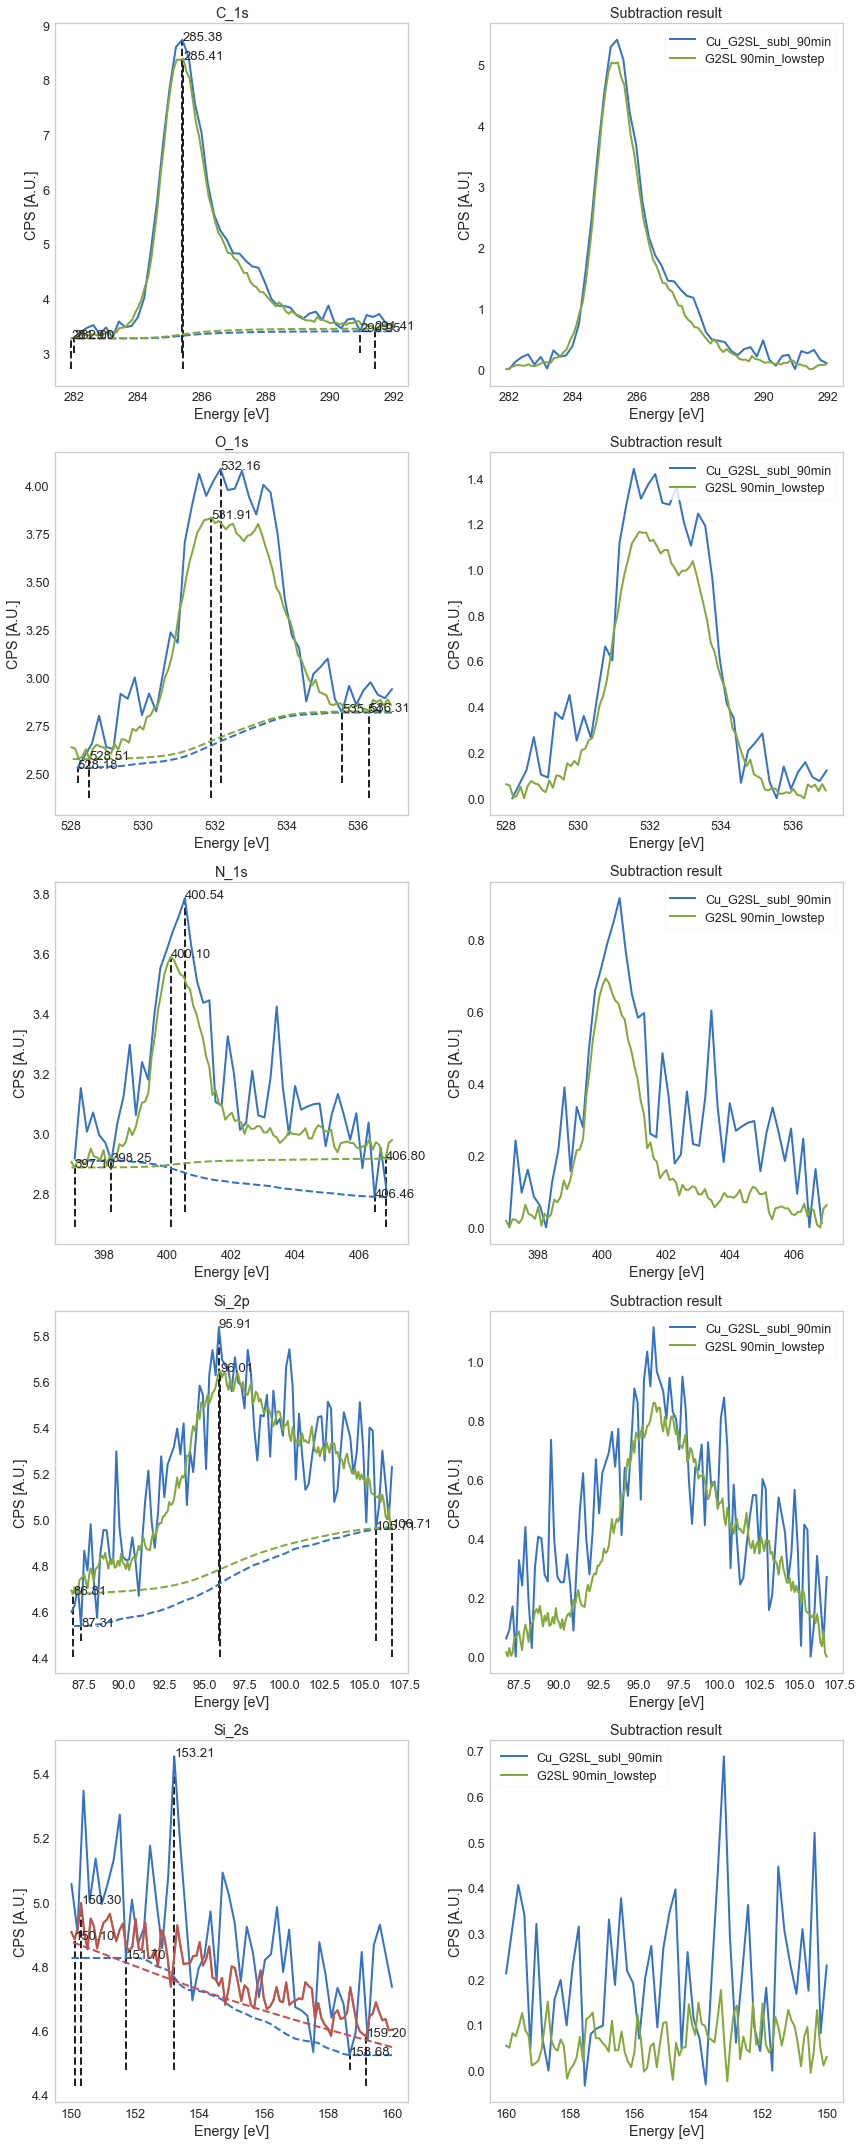

In [46]:
regions = ['C_1s', 'O_1s', 'N_1s', 'Si_2p', 'Si_2s']
bg_exps = bulk_bg_subtract(experiments, regions)

## Subtract double shirley to all Cu regions

KeyError in 'Cu_2p'


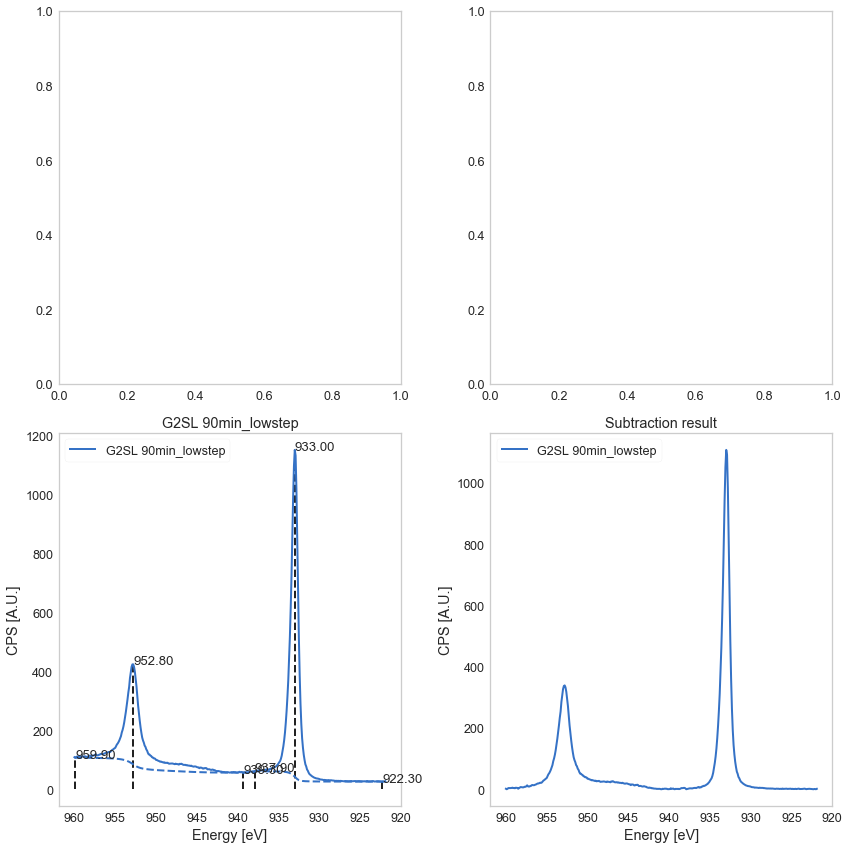

In [47]:
region = 'Cu_2p'

bg_exps = region_2bg_subtract(bg_exps, region=region, xlim=938)

#### Plot result of bulk subtract

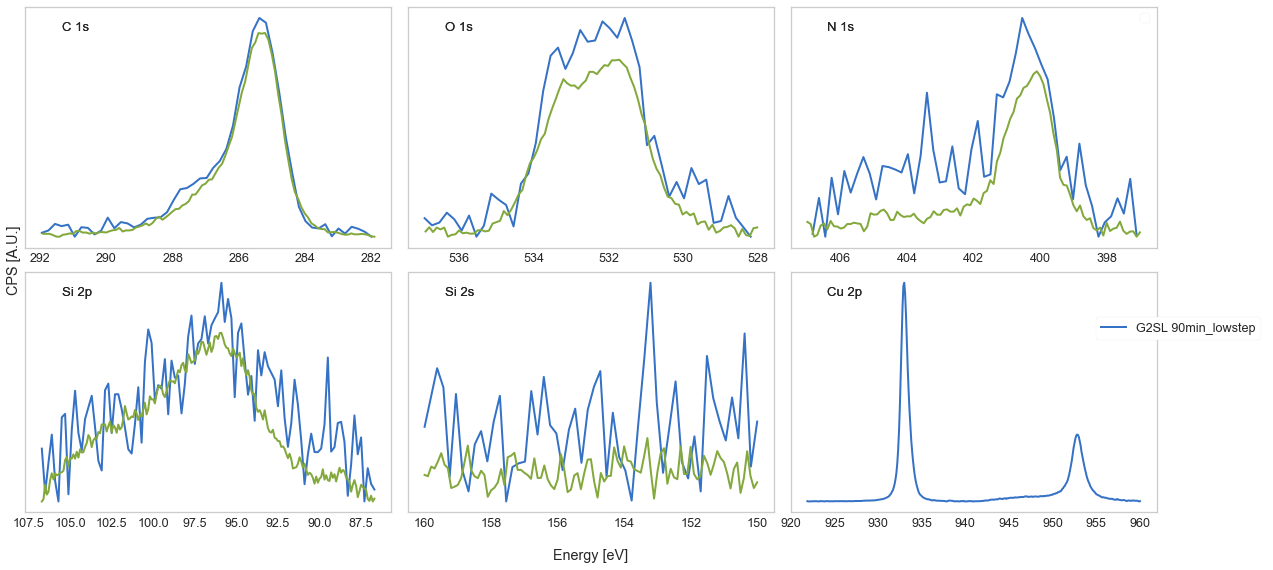

In [49]:
plot_xp_regions(bg_exps, regions + ['Cu_2p'], ncols=3);

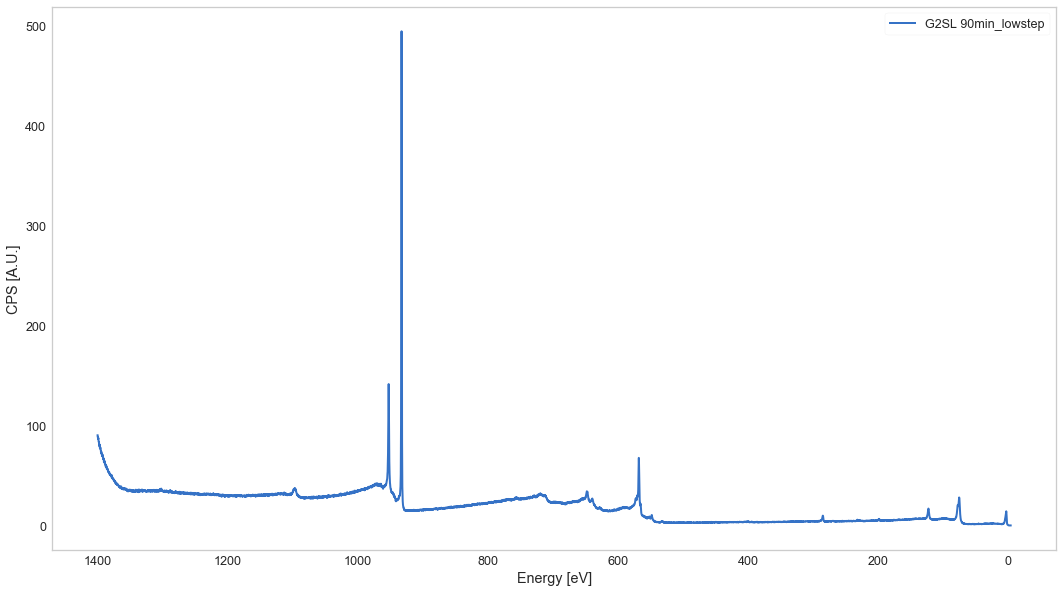

In [53]:
plt.figure(figsize=(18, 10))
plot_region(bg_exps[1], 'survey_hd')

In [81]:
regions

['C_1s', 'O_1s', 'N_1s', 'Si_2p', 'Si_2s']

In [97]:
experiments[0].dfx.columns

MultiIndex([(    'survey', 'energy'),
            (    'survey', 'counts'),
            (   'C_1s(2)', 'energy'),
            (   'C_1s(2)', 'counts'),
            (     'Si_2p', 'energy'),
            (     'Si_2p', 'counts'),
            (     'Na_1s', 'energy'),
            (     'Na_1s', 'counts'),
            (      'F_1s', 'energy'),
            (      'F_1s', 'counts'),
            (  'Ba_3d5/2', 'energy'),
            (  'Ba_3d5/2', 'counts'),
            (      'O_1s', 'energy'),
            (      'O_1s', 'counts'),
            (      'N_1s', 'energy'),
            (      'N_1s', 'counts'),
            (     'Si_2s', 'energy'),
            (     'Si_2s', 'counts'),
            ('survey_(2)', 'energy'),
            ('survey_(2)', 'counts'),
            (      'C_1s', 'energy'),
            (      'C_1s', 'counts'),
            ( 'survey_hd', 'energy'),
            ( 'survey_hd', 'counts')],
           names=['range', 'properties'])

In [101]:
insert_dfx_region(experiments[1], experiments[0], 'Ba_3d5/2', inplace=True);

[Text(0.5, 0, 'Energy (eV)')]

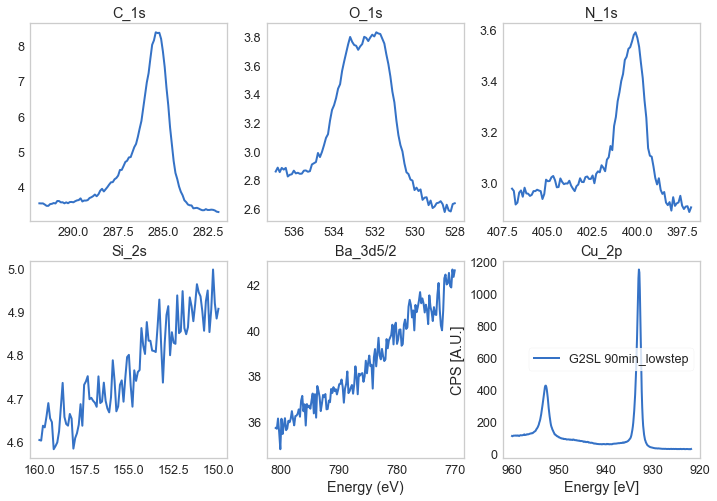

In [104]:
xp = experiments[1]
ncols = 3
regions = ['C_1s', 'O_1s', 'N_1s', 'Si_2s', 'Ba_3d5/2', 'Cu_2p']
fig, ax = plt.subplots(2, ncols, figsize=(12,8))
for i,r in enumerate(regions):
    j, k = i//ncols, i%ncols
    plot_region(xp, r, ax=ax[j][k])
#     cosmetics_plot(ax=ax[j,k])
    ax[j,k].invert_xaxis()
    ax[j,k].set(title=r)
ax[1,1].set(xlabel='Energy (eV)')

## Store processed experiments

In [54]:
import os
for xp, xpProc in zip(experiments, bg_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)

# Stoichiometry

In [56]:
for xp in bg_exps:
    xp.area = {}

'Si_2p' , asf missing, returning raw area
'Si_2p' , asf missing, returning raw area
'Si_2s' , asf missing, returning raw area
'Si_2s' , asf missing, returning raw area


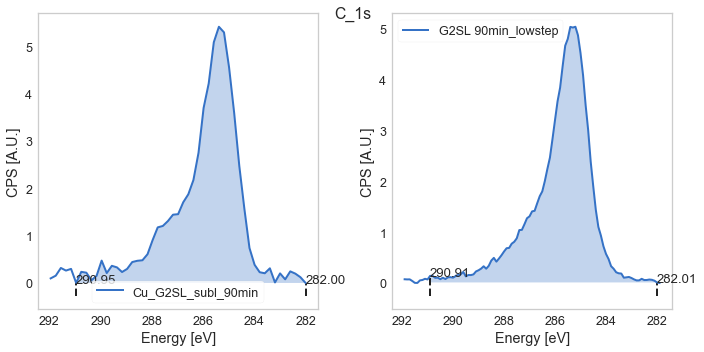

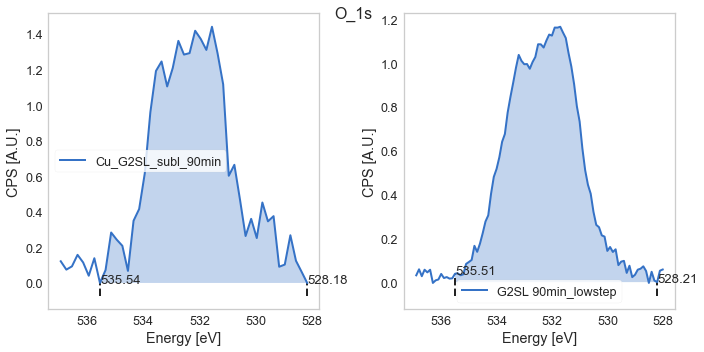

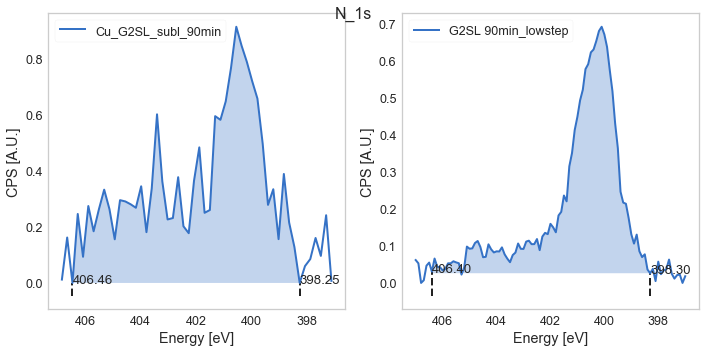

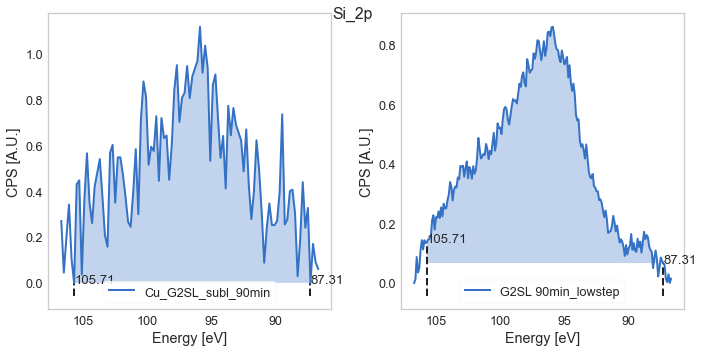

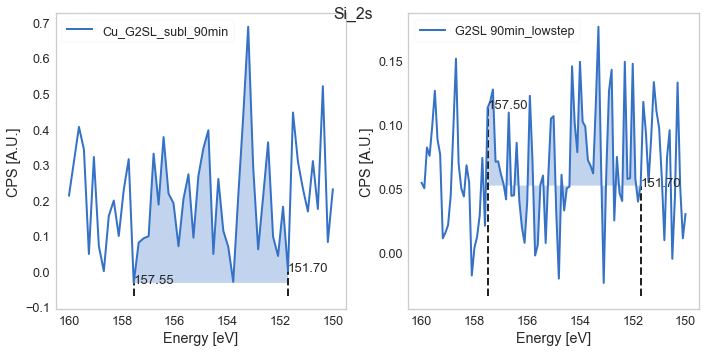

In [57]:
for r in regions:
    integrateRegions(bg_exps, r, asf)

## Result

In [108]:
a = {'C_1s': 12+6+6+5+2+1+3, 'N_1s': 4, 'O_1s': 9, 'Si_2p': 1}
g2sl = XPS_experiment(name='Sto. G2-SL', area=a)

aa = {'C_1s': 12+6+6+5+2+1+3, 'N_1s': 4, 'O_1s': 3, 'Si_2p': 1}
g2sl_short = XPS_experiment(name='Sto. G2-SL-short', area=aa)


b = {'C_1s': 12+6+6+5+2+1+3+6, 'N_1s': 5, 'O_1s': 9, 'Si_2p': 1}
g2sl_full = XPS_experiment(name='Sto. G2-SL-N', area=b)

g = {'C_1s': 12+6+6+5+2, 'N_1s': 3, 'O_1s': 5, 'Si_2p': 1}
g2 = XPS_experiment(name='Sto. G2', area=g)

dea = {'C_1s': 6+6+5+2+1+3, 'N_1s': 3, 'O_1s': 4, 'Si_2p': 1}
dea_sl = XPS_experiment(name='Sto. DEA-SL', area=dea)

In [109]:
num = ['C_1s', 'O_1s', 'C_1s', 'Si_2p']
denom = ['N_1s', 'N_1s', 'O_1s', 'N_1s']

display_stoichiometry(bg_exps + [g2sl, g2sl_short, g2sl_full, g2, dea_sl], num = num, denom = denom)

Si_2p  or  N_1s  was not measured
Si_2p  or  N_1s  was not measured


In [110]:
num = ['C_1s', 'O_1s', 'C_1s']
denom = ['N_1s', 'N_1s', 'O_1s']

make_stoichometry_table(bg_exps + [g2sl, g2sl_short, g2sl_full, g2, dea_sl], num = num, denom = denom, sep='\t')

Experiment	C_/N_	O_/N_	C_/O_	
Cu_G2SL_subl_90min	6.26 	 1.07 	 5.85 	 
G2SL 90min_lowstep	10.28 	 1.51 	 6.83 	 
Sto. G2-SL	8.75 	 2.25 	 3.89 	 
Sto. G2-SL-short	8.75 	 0.75 	 11.67 	 
Sto. G2-SL-N	8.20 	 1.80 	 4.56 	 
Sto. G2	10.33 	 1.67 	 6.20 	 
Sto. DEA-SL	7.67 	 1.33 	 5.75 	 


# Compare to G1

In [127]:
file = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210521_Au111_FBI_subl_45min.uxy'
g1au = read_processed_xp(file)

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210521_Au111_FBI_subl_45min.uxy.ft', returning empty fit dict


In [158]:
file = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_FBIG2_subl_20min.uxy'
g2au = read_processed_xp(file)

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_FBIG2_subl_20min.uxy.ft', returning empty fit dict


In [122]:
file = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210426_17-Cu_FBI_subl_60min.uxy'
g1cu = read_processed_xp(file)

In [162]:
trim_spectra(g2au, g1cu, 'O_1s', inplace=True);

In [141]:
trim_spectra(g1au, g1cu, 'O_1s', inplace=True);

In [163]:
norm = []
for xp in [bg_exps[1], g2au, g1cu, g1au]:
    xpn = normalise_dfx(xp)
    norm.append(xpn)

In [166]:
norm[0].name = 'G2-SL/Cu (microfocus)'
norm[1].name = 'G2/Au'
norm[2].name = 'G1/Cu'
norm[3].name = 'G1/Au'
norm[0].color = 'b'
norm[1].color = 'g'
norm[2].color = 'r'
norm[3].color = 'y'

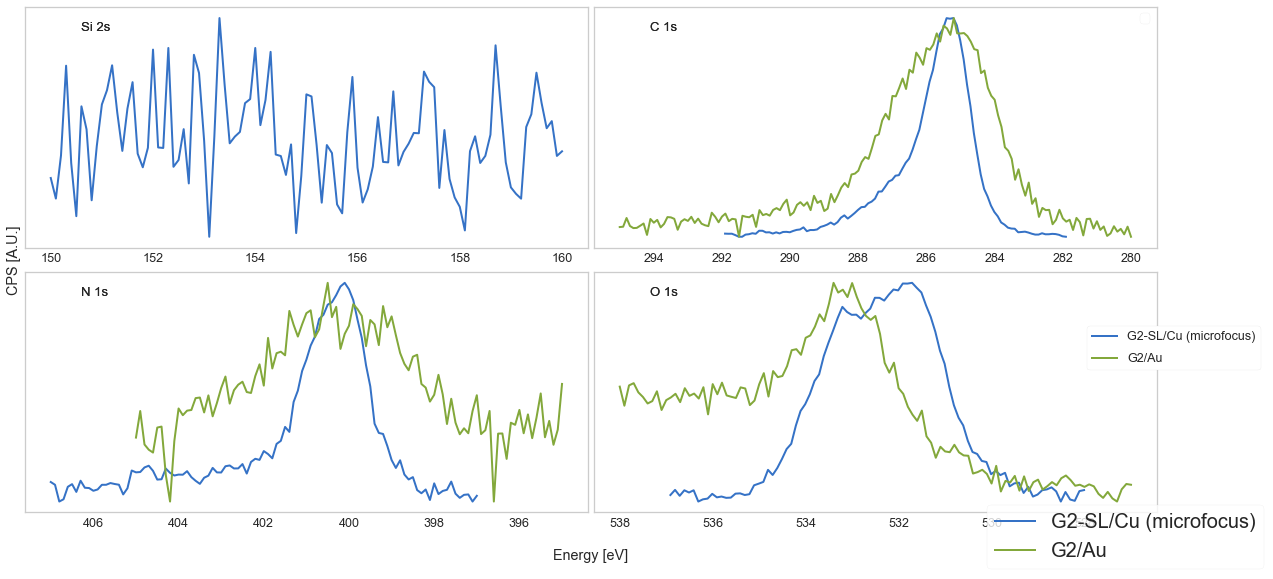

In [170]:
regions = ['Si_2s', 'C_1s', 'N_1s', 'O_1s',]
plot_xp_regions(norm[:2], regions, ncols=2);
plt.gcf().legend(loc='lower right', fontsize=20)

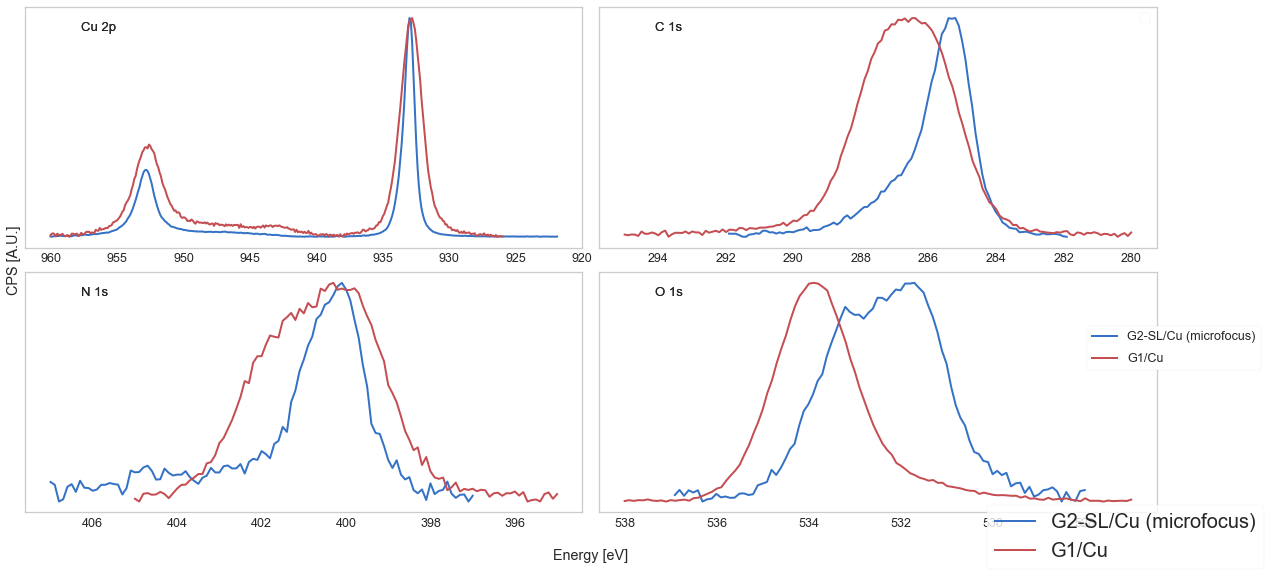

In [172]:
regions = ['Cu_2p', 'C_1s', 'N_1s', 'O_1s',]
plot_xp_regions([norm[0], norm[2]], regions, ncols=2);
plt.gcf().legend(loc='lower right', fontsize=20)

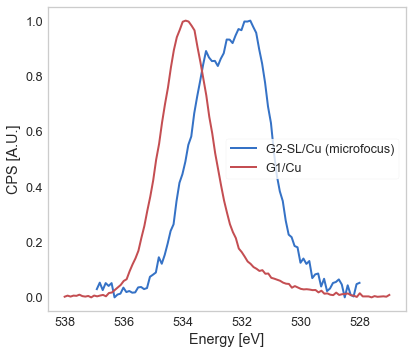

In [175]:
plot_region(norm[0], 'O_1s')
plot_region(norm[2], 'O_1s')
plt.gca().invert_xaxis()